## Rule-based classification with RandomForest

## Import Library dan Muat Dataset

memuat data awal dari file Excel dan menggabungkan data IB dan IK menjadi satu tabel.

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from collections import Counter
from wordcloud import WordCloud
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, silhouette_score, roc_auc_score, f1_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

## Data Preprocessing

Data preprocessing sangat penting dalam proyek berbasis data. Beberapa manfaat utama dari data preprocessing untuk proyek dan perusahaan meliputi:

Mempermudah proses data mining

Membuat data lebih mudah dibaca

Mengurangi beban representasi data

Mempercepat proses data mining secara signifikan

Memudahkan analisis data dalam machine learning

In [7]:
file_path = "dataset.xlsx"

ib_data = pd.read_excel(file_path, sheet_name="DATA IB")
ik_data = pd.read_excel(file_path, sheet_name="DATA IK")

# kolom yang relevan --> 'keperluan'
ib_data = ib_data[["desc"]].rename(columns={"desc": "keperluan"})
ik_data = ik_data[["tujuan"]].rename(columns={"tujuan": "keperluan"})

ib_data["izin"] = "IB"
ik_data["izin"] = "IK"

combined_data = pd.concat([ib_data, ik_data], ignore_index=True)

# Bersihkan teks pada kolom 'keperluan'
combined_data["keperluan"] = combined_data["keperluan"].str.strip().str.lower()
combined_data.drop_duplicates(subset=['keperluan'], inplace=True)

combined_data.to_csv("combined_ib_ik_keperluan.csv", index=False)

print(combined_data.info(['keperluan']))
#print(combined_data.head)

<class 'pandas.core.frame.DataFrame'>
Index: 3439 entries, 0 to 80365
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   keperluan  3439 non-null   object
 1   izin       3439 non-null   object
dtypes: object(2)
memory usage: 80.6+ KB
None


## Exploratory Data Analysis (EDA)

Menganalisis informasi data yang telah digabungkan.

In [3]:
# Muat data
file_path = "combined_ib_ik_keperluan.csv"
data = pd.read_csv(file_path)

# Tampilkan informasi data
print(data.info())
print(data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3439 entries, 0 to 3438
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   keperluan  3439 non-null   object
 1   izin       3439 non-null   object
dtypes: object(2)
memory usage: 53.9+ KB
None
                        keperluan izin
0         ingin bertemu orang tua   IB
1               libur akhir tahun   IB
2                  libur semester   IB
3               bertemu orang tua   IB
4  mengerjakan tugas proyek akhir   IB


## Visualisasi Distribusi Kata pada Data "Keperluan"

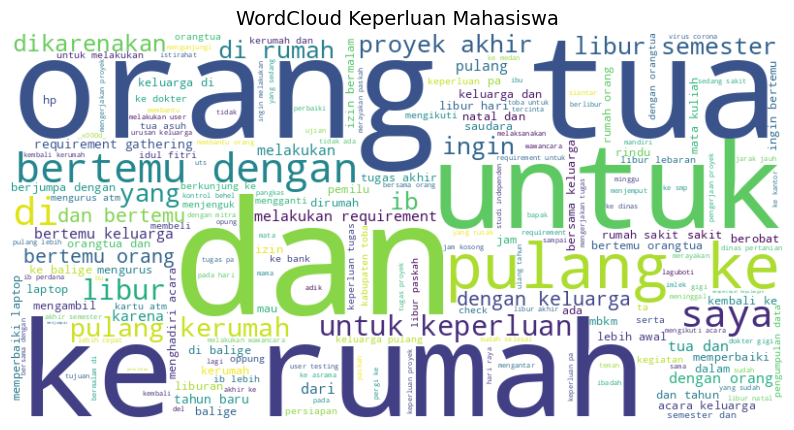

10 Kata Paling Umum dalam Keperluan:
dan: 807
ke: 678
untuk: 492
rumah: 402
pulang: 385
libur: 373
di: 360
keluarga: 352
bertemu: 346
orang: 341
tua: 304
melakukan: 294
dengan: 277
yang: 247
keperluan: 233
kerumah: 180
requirement: 172
ingin: 170
proyek: 166
ib: 161


In [4]:
# Hitung distribusi kata
all_keperluan = " ".join(data["keperluan"])
word_counts = Counter(all_keperluan.split())

# Tampilkan WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_keperluan)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud Keperluan Mahasiswa", fontsize=14)
plt.show()

# Tampilkan kata paling umum
common_words = word_counts.most_common(20)
print("10 Kata Paling Umum dalam Keperluan:")
for word, count in common_words:
    print(f"{word}: {count}")


## Klasifikasi Data Berdasarkan Aturan

Mengklasifikasikan data kolom keperluan menjadi beberapa kategori menggunakan aturan berbasis regex.

In [5]:
# Klasifikasi keperluan
def classify_keperluan(text):
    if re.search(r"(laptop|printer|service|barang)", text):
        return "Memperbaiki Barang"
    elif re.search(r"(orangtua|orang tua|keluarga|saudara|pulang|rumah|bertemu|libur|pemilu|ib|pesta|pernikahan|natal|lebaran|paskah|acara|izin bermalam)", text):
        return "Bertemu Keluarga"
    elif re.search(r"(proyek akhir|PKM|tugas|makalah|requirement|observasi|pa 1|pa 2| pa 3|tugas akhir|akhir|data)", text):
        return "Tugas Kuliah"
    elif re.search(r"(kontrol|gigi|behel|cabut|sakit|berobat|obat)", text):
        return "Pergi ke Klinik"
    elif re.search(r"(membeli|barang|pribadi|mengurus|keperluan|rekening|tabungan|kartu)", text):
        return "Urusan Pribadi"
    elif re.search(r"(exit|clearance|wisuda)", text):
        return "Tamat Kuliah"
    else:
        return "Lainnya"

data["kategori"] = data["keperluan"].apply(classify_keperluan)


print(data["kategori"].value_counts())

data.to_csv("categorized_keperluan.csv", index=False)


kategori
Bertemu Keluarga      1942
Lainnya                690
Tugas Kuliah           334
Urusan Pribadi         191
Memperbaiki Barang     141
Pergi ke Klinik        121
Tamat Kuliah            20
Name: count, dtype: int64


In [6]:
opp_data = pd.read_csv("categorized_keperluan.csv")
opp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3439 entries, 0 to 3438
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   keperluan  3439 non-null   object
 1   izin       3439 non-null   object
 2   kategori   3439 non-null   object
dtypes: object(3)
memory usage: 80.7+ KB


## Label Encoding

Konversi kategori menjadi nilai numerik.

In [7]:
label_encoder = LabelEncoder()

# Mengencode semua kolom bertipe 'object'
for column in opp_data.select_dtypes(include=["object"]).columns:
    opp_data[column + "_encoded"] = label_encoder.fit_transform(opp_data[column])

print("Data Setelah Encoding:")
print(opp_data.head())

opp_data.info()

Data Setelah Encoding:
                        keperluan izin          kategori  keperluan_encoded  \
0         ingin bertemu orang tua   IB  Bertemu Keluarga                701   
1               libur akhir tahun   IB  Bertemu Keluarga               1171   
2                  libur semester   IB  Bertemu Keluarga               1345   
3               bertemu orang tua   IB  Bertemu Keluarga                365   
4  mengerjakan tugas proyek akhir   IB      Tugas Kuliah               2140   

   izin_encoded  kategori_encoded  
0             0                 0  
1             0                 0  
2             0                 0  
3             0                 0  
4             0                 5  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3439 entries, 0 to 3438
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   keperluan          3439 non-null   object
 1   izin               3439 non-null  

## Tingkatkan Representasi Fitur

Dengan TF-IDF (Term Frequency Inverse Document Frequency), merupakan metode yang digunakan untuk menentukan nilai frekuensi sebuah kata di dalam sebuah dokumen atau artikel dan juga frekuensi di dalam banyak dokumen. Perhitungan ini menentukan seberapa relevan sebuah kata di dalam sebuah dokumen.

In [8]:
tfidf = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf.fit_transform(opp_data["keperluan"])


## Proses Pemodelan

Pemodelan menggunakan Random Forest.
RandomForest bekerja baik dengan fitur numerik yang berasal dari encoding seperti kategori_encoded, izin_encoded, dan keperluan_encoded.

Random forest (RF) adalah suatu algoritma yang digunakan pada klasifikasi data dalam jumlah yang besar.

Klasifikasi random forest dilakukan melalui penggabungan pohon (tree) dengan melakukan training pada sampel data yang dimiliki.

In [11]:
# Memisahkan fitur dan target
X = np.hstack((X_tfidf.toarray(), opp_data[["izin_encoded"]].values))
y = opp_data["kategori_encoded"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model
model = RandomForestClassifier(class_weight="balanced", max_depth=None, n_estimators=100)
model.fit(X_train, y_train)

# Evaluasi
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       391
           1       0.94      0.95      0.95       147
           2       1.00      0.88      0.94        26
           3       0.95      0.83      0.89        24
           4       0.50      0.75      0.60         4
           5       0.94      0.95      0.95        64
           6       0.84      0.97      0.90        32

    accuracy                           0.96       688
   macro avg       0.88      0.90      0.88       688
weighted avg       0.96      0.96      0.96       688

Accuracy: 0.96


## Hyperparameter Tuning

Gunakan GridSearchCV atau Optuna untuk mencari parameter terbaik.

In [10]:
param_grid = {
    "n_estimators": [50, 100, 150],
    "max_depth": [None, 10, 20],
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Best Params:", grid_search.best_params_)


Best Params: {'max_depth': None, 'n_estimators': 100}


## Evaluasi Model

Gunakan metrik seperti accuracy, F1-score, dan confusion matrix.

In [12]:
scores = cross_val_score(model, X, y, cv=5, scoring="accuracy")
print(f"Mean Accuracy: {scores.mean():.2f}")


Mean Accuracy: 0.88


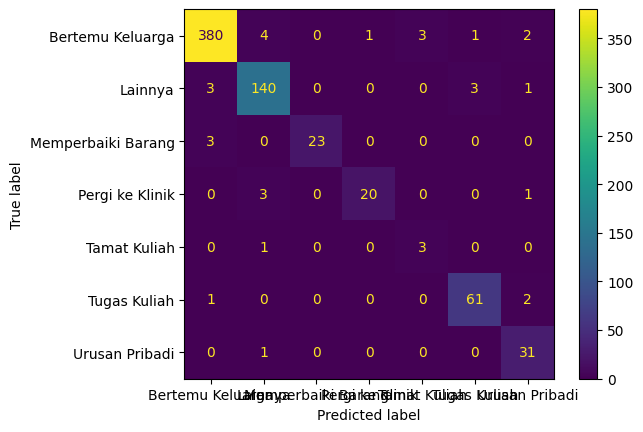

In [13]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=label_encoder.classes_)
plt.show()


## Ekstraksi Insight Bisnis.

1. Analisis Distribusi Kategori Prediksi

Identifikasi distribusi prediksi kategori pada data testing.

Gunakan ini untuk memahami kategori mana yang paling dominan dan potensial untuk peluang bisnis.

Distribusi Kategori Prediksi:
Kategori 0: 387 data
Kategori 5: 65 data
Kategori 3: 21 data
Kategori 1: 149 data
Kategori 6: 37 data
Kategori 2: 23 data
Kategori 4: 6 data


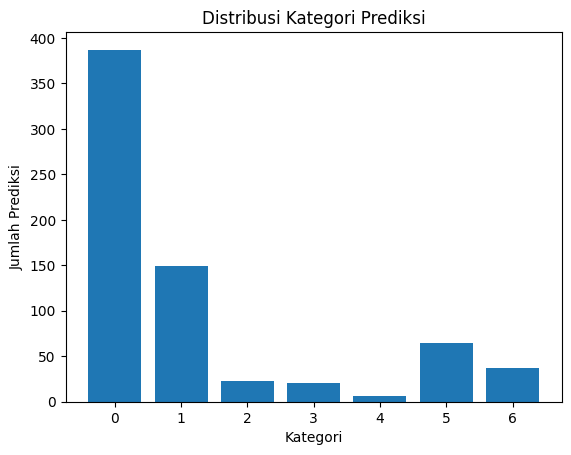

In [14]:
# Prediksi pada data testing
y_pred = model.predict(X_test)

# Distribusi kategori
category_counts = Counter(y_pred)
print("Distribusi Kategori Prediksi:")
for category, count in category_counts.items():
    print(f"Kategori {category}: {count} data")

# Visualisasi
plt.bar(category_counts.keys(), category_counts.values())
plt.xlabel("Kategori")
plt.ylabel("Jumlah Prediksi")
plt.title("Distribusi Kategori Prediksi")
plt.show()


 2. Analisis Kata Kunci Dominan (TF-IDF)

Identifikasi kata-kata yang memiliki bobot TF-IDF tinggi untuk setiap kategori. 

Ini membantu memahami keperluan spesifik mahasiswa yang terkait dengan kategori tertentu.

In [15]:
# Pisahkan data berdasarkan kategori
categories = opp_data["kategori"].unique()

for category in categories:
    category_data = opp_data[opp_data["kategori"] == category]["keperluan"]
    tfidf = TfidfVectorizer(max_features=10)  # Ambil 10 fitur teratas
    X_tfidf = tfidf.fit_transform(category_data)
    feature_names = tfidf.get_feature_names_out()
    
    # Print kata-kata dominan
    print(f"\nKategori: {category}")
    print("Kata-Kata Dominan:")
    for word, score in zip(feature_names, X_tfidf.toarray().mean(axis=0)):
        print(f"{word}: {score:.4f}")



Kategori: Bertemu Keluarga
Kata-Kata Dominan:
bertemu: 0.1047
dan: 0.1506
ke: 0.1139
keluarga: 0.1402
libur: 0.1545
orang: 0.0940
pulang: 0.1317
rumah: 0.1348
tua: 0.0909
untuk: 0.0718

Kategori: Tugas Kuliah
Kata-Kata Dominan:
akhir: 0.1711
dan: 0.1149
ke: 0.1589
keperluan: 0.1295
melakukan: 0.1827
pa: 0.1500
proyek: 0.1836
requirement: 0.2455
tugas: 0.1571
untuk: 0.1945

Kategori: Lainnya
Kata-Kata Dominan:
balige: 0.0467
dan: 0.0790
di: 0.0771
hp: 0.0300
ke: 0.1110
melakukan: 0.0513
memperbaiki: 0.0593
testing: 0.0343
untuk: 0.0562
yang: 0.0455

Kategori: Pergi ke Klinik
Kata-Kata Dominan:
behel: 0.1819
berobat: 0.1861
dan: 0.1348
di: 0.0670
dokter: 0.1009
gigi: 0.2591
ke: 0.1121
kontrol: 0.1750
sakit: 0.1004
yang: 0.0776

Kategori: Urusan Pribadi
Kata-Kata Dominan:
atm: 0.1420
balige: 0.1050
bank: 0.0826
dan: 0.1366
kartu: 0.0876
ke: 0.1111
keperluan: 0.2832
mengurus: 0.2195
untuk: 0.1905
yang: 0.1038

Kategori: Memperbaiki Barang
Kata-Kata Dominan:
balige: 0.0732
barang: 0.1553
b

In [16]:
# Tambahkan prediksi ke dataframe
opp_data["predicted_category"] = model.predict(X)

# Analisis kata-kata dominan pada kategori prediksi
for category in opp_data["predicted_category"].unique():
    category_data = opp_data[opp_data["predicted_category"] == category]["keperluan"]
    tfidf = TfidfVectorizer(max_features=10)
    X_tfidf = tfidf.fit_transform(category_data)
    feature_names = tfidf.get_feature_names_out()

    print(f"\nPrediksi Kategori: {category}")
    print("Kata-Kata Dominan:")
    for word, score in zip(feature_names, X_tfidf.toarray().mean(axis=0)):
        print(f"{word}: {score:.4f}")



Prediksi Kategori: 0
Kata-Kata Dominan:
bertemu: 0.1058
dan: 0.1524
ke: 0.1153
keluarga: 0.1409
libur: 0.1554
orang: 0.0948
pulang: 0.1323
rumah: 0.1358
tua: 0.0917
untuk: 0.0726

Prediksi Kategori: 5
Kata-Kata Dominan:
akhir: 0.1716
dan: 0.1127
ke: 0.1588
keperluan: 0.1257
melakukan: 0.1822
pa: 0.1551
proyek: 0.1851
requirement: 0.2454
tugas: 0.1566
untuk: 0.1921

Prediksi Kategori: 1
Kata-Kata Dominan:
balige: 0.0460
dan: 0.0788
di: 0.0760
hp: 0.0296
ke: 0.1086
melakukan: 0.0509
memperbaiki: 0.0585
testing: 0.0337
untuk: 0.0521
yang: 0.0447

Prediksi Kategori: 3
Kata-Kata Dominan:
behel: 0.1864
berobat: 0.1903
dan: 0.1238
di: 0.0688
dokter: 0.1078
gigi: 0.2604
ke: 0.1152
kontrol: 0.1826
sakit: 0.1029
yang: 0.0795

Prediksi Kategori: 6
Kata-Kata Dominan:
atm: 0.1436
balige: 0.1029
bank: 0.0786
dan: 0.1358
kartu: 0.0857
ke: 0.1090
keperluan: 0.2904
mengurus: 0.2248
untuk: 0.1981
yang: 0.1018

Prediksi Kategori: 2
Kata-Kata Dominan:
balige: 0.0744
barang: 0.1482
bertemu: 0.0695
dan: 0.

## Evaluasi Model (Tambahan)

In [17]:
# Multi-class ROC-AUC
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test), multi_class="ovr")
print(f"ROC-AUC Score: {roc_auc:.2f}")

# F1 Score per kategori
f1 = f1_score(y_test, y_pred, average="weighted")
print(f"F1 Score: {f1:.2f}")


ROC-AUC Score: 1.00
F1 Score: 0.96


## Eksplorasi Peluang Bisnis dengan Clustering

Untuk menemukan pola peluang bisnis:

1. Terapkan clustering pada data fitur menggunakan metode seperti KMeans untuk menemukan kelompok tujuan yang serupa.
2. Visualisasikan hasil clustering dan analisis kategori dominan dari setiap klaster.

###### Clustering dengan KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_tfidf)

# Visualisasi dengan PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf.toarray())

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap="viridis")
plt.title("Clustering Hasil TF-IDF")
plt.xlabel("Komponen PCA 1")
plt.ylabel("Komponen PCA 2")
plt.show()


## Analisis Hasil Clustering (Klasterisasi Semua Data)

Analisis lebih lanjut hasil clustering untuk memahami pola:

1. Periksa jumlah data dalam setiap klaster.
2. Lihat distribusi kategori di setiap klaster.
3. Analisis hubungan antara klaster dan kategori yang telah diklasifikasikan sebelumnya.

cluster  kategori          
0        Bertemu Keluarga      1139
         Lainnya                690
         Tugas Kuliah           334
         Urusan Pribadi         191
         Memperbaiki Barang     127
         Pergi ke Klinik        121
         Tamat Kuliah            20
1        Bertemu Keluarga       340
         Memperbaiki Barang       1
2        Bertemu Keluarga       463
         Memperbaiki Barang      13
Name: count, dtype: int64


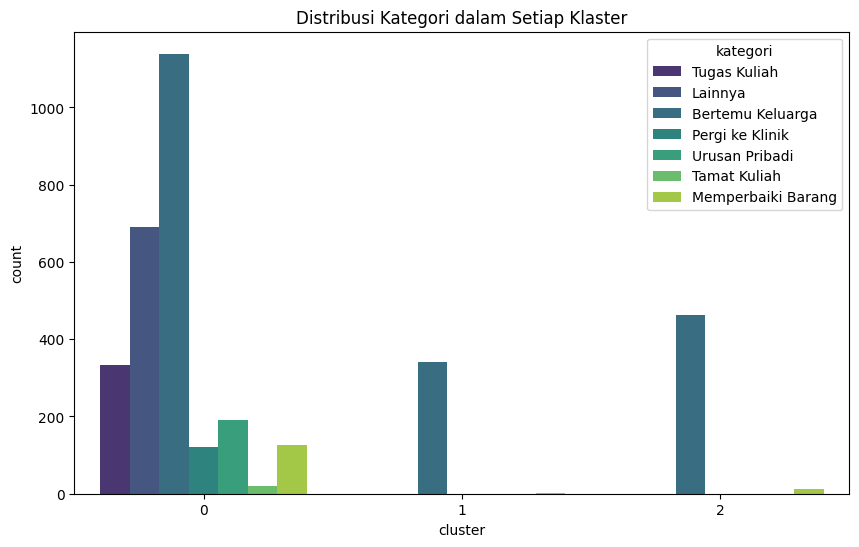

In [20]:
# Ulangi TF-IDF pada seluruh data
tfidf_full = TfidfVectorizer(max_features=1000)
X_tfidf_full = tfidf_full.fit_transform(opp_data["keperluan"])

# Klasterisasi
kmeans_full = KMeans(n_clusters=3, random_state=42)
clusters_full = kmeans_full.fit_predict(X_tfidf_full)

# Tambahkan hasil klaster ke dalam opp_data
opp_data["cluster"] = clusters_full

# Analisis distribusi
print(opp_data.groupby("cluster")["kategori"].value_counts())

# Visualisasi distribusi kategori dalam klaster

plt.figure(figsize=(10, 6))
sns.countplot(x="cluster", hue="kategori", data=opp_data, palette="viridis")
plt.title("Distribusi Kategori dalam Setiap Klaster")
plt.show()


## Optimasi Jumlah Klaster
Mencari jumlah klaster optimal menggunakan Elbow Method atau Silhouette Analysis.

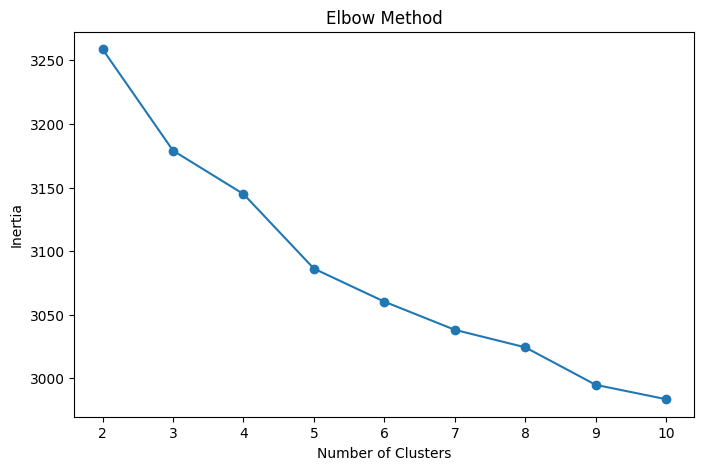

In [22]:
# Elbow Method
inertia = []
k_values = range(2, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_tfidf_full)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker="o")
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()


In [23]:
# Uji berbagai jumlah klaster
for n_clusters in range(2, 10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X_tfidf)
    score = silhouette_score(X_tfidf, labels)
    print(f"Jumlah Klaster: {n_clusters}, Silhouette Score: {score:.2f}")


Jumlah Klaster: 2, Silhouette Score: 0.31
Jumlah Klaster: 3, Silhouette Score: 0.38
Jumlah Klaster: 4, Silhouette Score: 0.49
Jumlah Klaster: 5, Silhouette Score: 0.55
Jumlah Klaster: 6, Silhouette Score: 0.57
Jumlah Klaster: 7, Silhouette Score: 0.68
Jumlah Klaster: 8, Silhouette Score: 0.75
Jumlah Klaster: 9, Silhouette Score: 0.73


## Rangkuman Kategori Dominan

Identifikasi kategori dominan di setiap klaster, rangkum dalam bentuk tabel, dan visualisasikan distribusinya.

   Cluster  Kategori Dominan  Persentase
0        0  Bertemu Keluarga       43.44
1        1  Bertemu Keluarga       99.71
2        2  Bertemu Keluarga       97.27


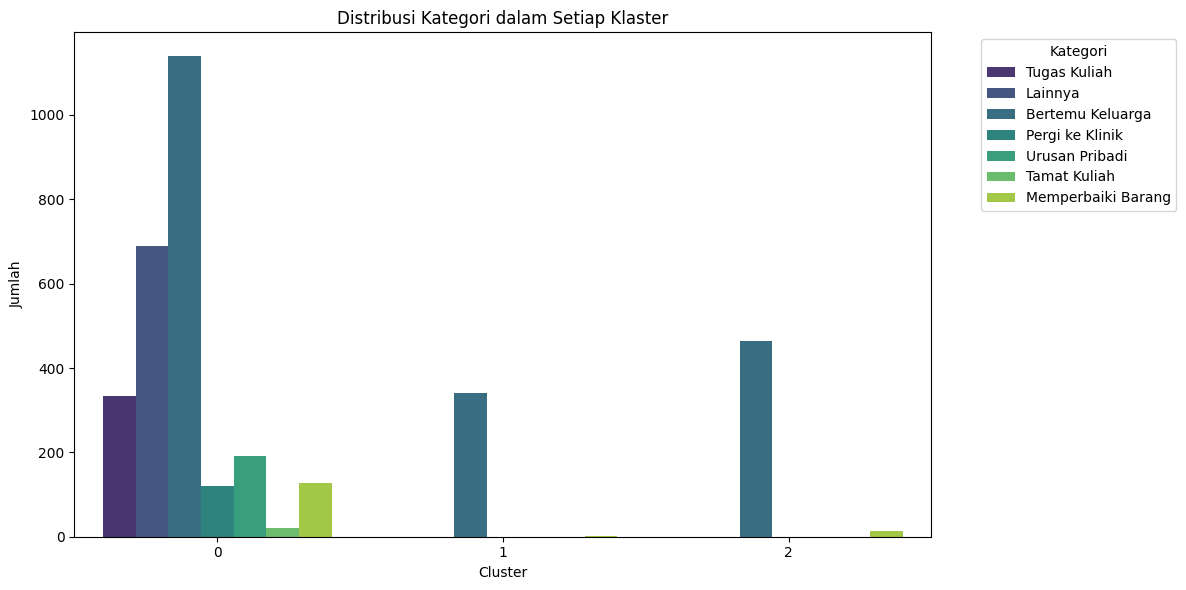

In [21]:
# Hitung kategori dominan per klaster
dominant_categories = opp_data.groupby("cluster")["kategori"].value_counts(normalize=True).unstack().idxmax(axis=1)
category_percentages = opp_data.groupby("cluster")["kategori"].value_counts(normalize=True).unstack().max(axis=1)

# Buat DataFrame untuk merangkum
summary_table = pd.DataFrame({
    "Cluster": dominant_categories.index,
    "Kategori Dominan": dominant_categories.values,
    "Persentase": (category_percentages.values * 100).round(2)
})
print(summary_table)

# Visualisasi distribusi kategori per klaster
plt.figure(figsize=(12, 6))
sns.countplot(x="cluster", hue="kategori", data=opp_data, palette="viridis")
plt.title("Distribusi Kategori dalam Setiap Klaster")
plt.xlabel("Cluster")
plt.ylabel("Jumlah")
plt.legend(title="Kategori", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


## Hubungkan Kategori dengan Peluang Bisnis

Gunakan hasil kategori dominan untuk memberikan rekomendasi peluang bisnis.

In [23]:
# Tambahkan rekomendasi peluang bisnis
recommendations = {
    "Bertemu Keluarga": "Jasa Transportasi",
    "Pergi ke Klinik": "Klinik Kesehatan atau Apotek",
    "Tugas Kuliah": "Pusat Fotokopi atau Jasa Pengetikan",
    "Memperbaiki Barang": "Toko Elektronik atau Reparasi Barang",
    "Urusan Pribadi": "Layanan Logistik atau Perjalanan",
    "Tamat Kuliah": "Jasa Fotografi atau Penyewaan Kostum",
    "Lainnya": "Usaha General seperti Minimarket"
}

summary_table["Peluang Bisnis"] = summary_table["Kategori Dominan"].map(recommendations)
print(summary_table)


   Cluster  Kategori Dominan  Persentase     Peluang Bisnis
0        0  Bertemu Keluarga       43.44  Jasa Transportasi
1        1  Bertemu Keluarga       99.71  Jasa Transportasi
2        2  Bertemu Keluarga       97.27  Jasa Transportasi
